In [7]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.9 MB/s eta 0:00:00


In [8]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/ml-100k.zip'

output_dir = 'movielens_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Fichiers extraits dans : {os.listdir(output_dir)}")


Fichiers extraits dans : ['ml-100k']


In [9]:
# Étape 1 : Charger les données
import pandas as pd
import numpy as np

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('/content/movielens_data/ml-100k/u.data', sep='\t', names=column_names)
data.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
import pandas as pd
import torch
from torch_geometric.data import Data

# Load the dataset
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('/content/movielens_data/ml-100k/u.data', sep='\t', names=column_names)

# Map user and item IDs to a contiguous range (0, ..., n-1)
# This ensures compatibility with PyTorch Geometric
data['user_id'] = data['user_id'] - 1  # Convert 1-based to 0-based indexing
data['item_id'] = data['item_id'] - 1  # Convert 1-based to 0-based indexing

# Create edge indices for the user-item bipartite graph
user_ids = torch.tensor(data['user_id'].values, dtype=torch.long)
item_ids = torch.tensor(data['item_id'].values, dtype=torch.long)

# Concatenate user and item edges
# LightGCN requires bi-directional edges
edge_index = torch.cat([
    torch.stack([user_ids, item_ids + data['user_id'].nunique()]),  # User-to-Item edges
    torch.stack([item_ids + data['user_id'].nunique(), user_ids])   # Item-to-User edges
], dim=1)

# Ratings as edge attributes
ratings = torch.tensor(data['rating'].values, dtype=torch.float)

# Create a PyTorch Geometric Data object
num_users = data['user_id'].nunique()
num_items = data['item_id'].nunique()
num_nodes = num_users + num_items

# Initialize trainable embeddings for nodes (optional, can be done in the model)
embedding_dim = 64
node_embeddings = torch.nn.Embedding(num_nodes, embedding_dim)

# PyTorch Geometric Data Object with ratings as edge attributes
graph_data = Data(edge_index=edge_index, edge_attr=ratings)
graph_data.num_users = num_users
graph_data.num_items = num_items

# Check the Data object
print(graph_data)


Data(edge_index=[2, 200000], edge_attr=[100000], num_users=943, num_items=1682)


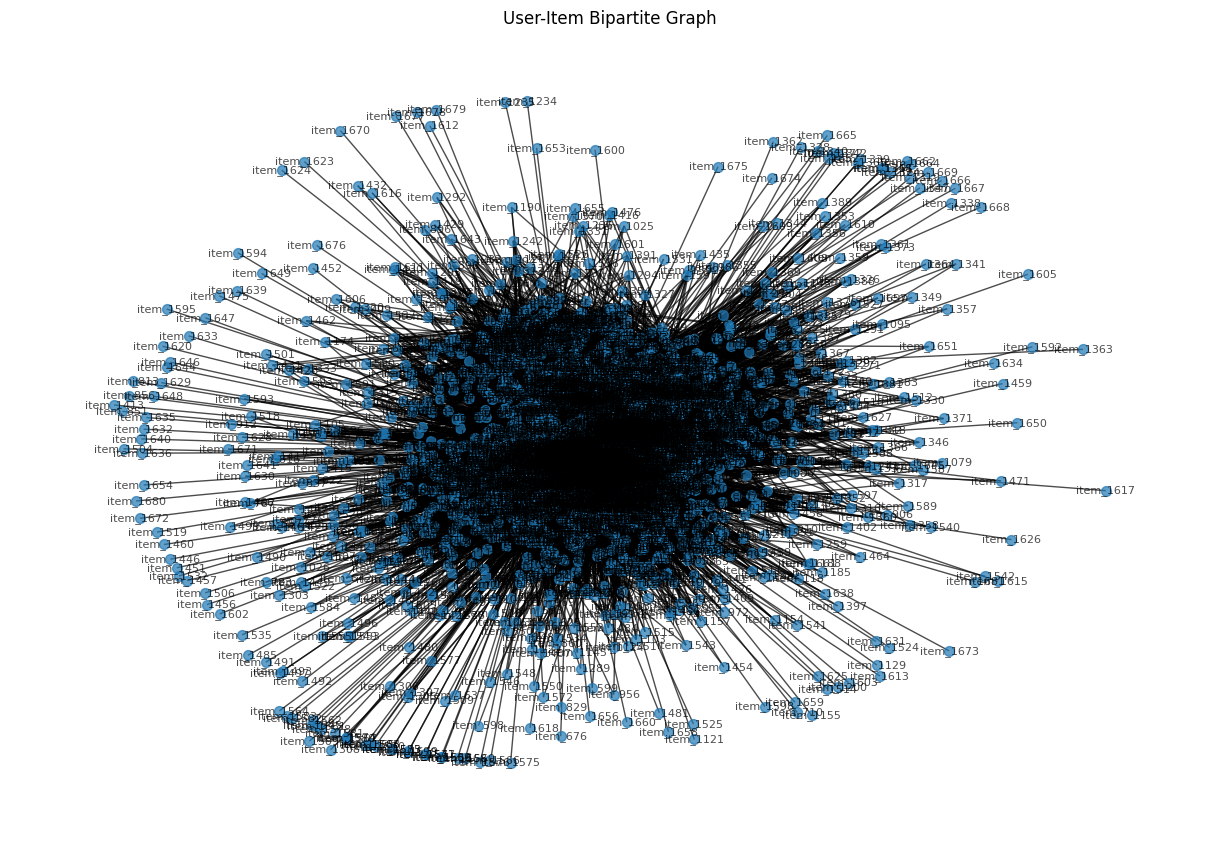

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric graph to NetworkX graph for visualization
def visualize_graph(data):
    edge_index = data.edge_index.numpy()  # Convert edge_index to numpy
    num_users = data.num_users
    num_items = data.num_items

    # Create a NetworkX graph
    G = nx.Graph()

    # Add user nodes (label them as "user_0", "user_1", ...)
    user_nodes = [f'user_{i}' for i in range(num_users)]
    G.add_nodes_from(user_nodes, bipartite=0)

    # Add item nodes (label them as "item_0", "item_1", ...)
    item_nodes = [f'item_{i}' for i in range(num_items)]
    G.add_nodes_from(item_nodes, bipartite=1)

    # Add edges between users and items
    for src, dest in zip(edge_index[0], edge_index[1]):
        if src < num_users:  # Map user indices back to labels
            src_label = f'user_{src}'
        else:
            src_label = f'item_{src - num_users}'

        if dest < num_users:  # Map item indices back to labels
            dest_label = f'user_{dest}'
        else:
            dest_label = f'item_{dest - num_users}'

        G.add_edge(src_label, dest_label)

    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, alpha=0.7)
    plt.title("User-Item Bipartite Graph")
    plt.show()

# Visualize the graph
visualize_graph(graph_data)
